In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, mean_squared_log_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [20]:
train_df = pd.read_csv('train.csv', index_col='id')
train_df.rename(columns={
    'Whole weight':'Whole_weight', 
    'Whole weight.1':'Whole_weight_1',
    'Whole weight.2':'Whole_weight_2',
    'Shell weight':'Shell_weight'}, inplace=True)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole_weight    90615 non-null  float64
 5   Whole_weight_1  90615 non-null  float64
 6   Whole_weight_2  90615 non-null  float64
 7   Shell_weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.9+ MB


,Sex,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [21]:
test_df = pd.read_csv('test.csv',index_col='id')
test_df.rename(columns={
    'Whole weight':'Whole_weight', 
    'Whole weight.1':'Whole_weight_1',
    'Whole weight.2':'Whole_weight_2',
    'Shell weight':'Shell_weight'}, inplace=True)
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 60411 entries, 90615 to 151025
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             60411 non-null  object 
 1   Length          60411 non-null  float64
 2   Diameter        60411 non-null  float64
 3   Height          60411 non-null  float64
 4   Whole_weight    60411 non-null  float64
 5   Whole_weight_1  60411 non-null  float64
 6   Whole_weight_2  60411 non-null  float64
 7   Shell_weight    60411 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.1+ MB


,Sex,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [22]:
train_df.describe()

,Length,Diameter,Height,Whole_weight,Whole_weight_1,Whole_weight_2,Shell_weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole_weight'}>,
        <Axes: title={'center': 'Whole_weight_1'}>,
        <Axes: title={'center': 'Whole_weight_2'}>],
       [<Axes: title={'center': 'Shell_weight'}>,
        <Axes: title={'center': 'Rings'}>, <Axes: >]], dtype=object)

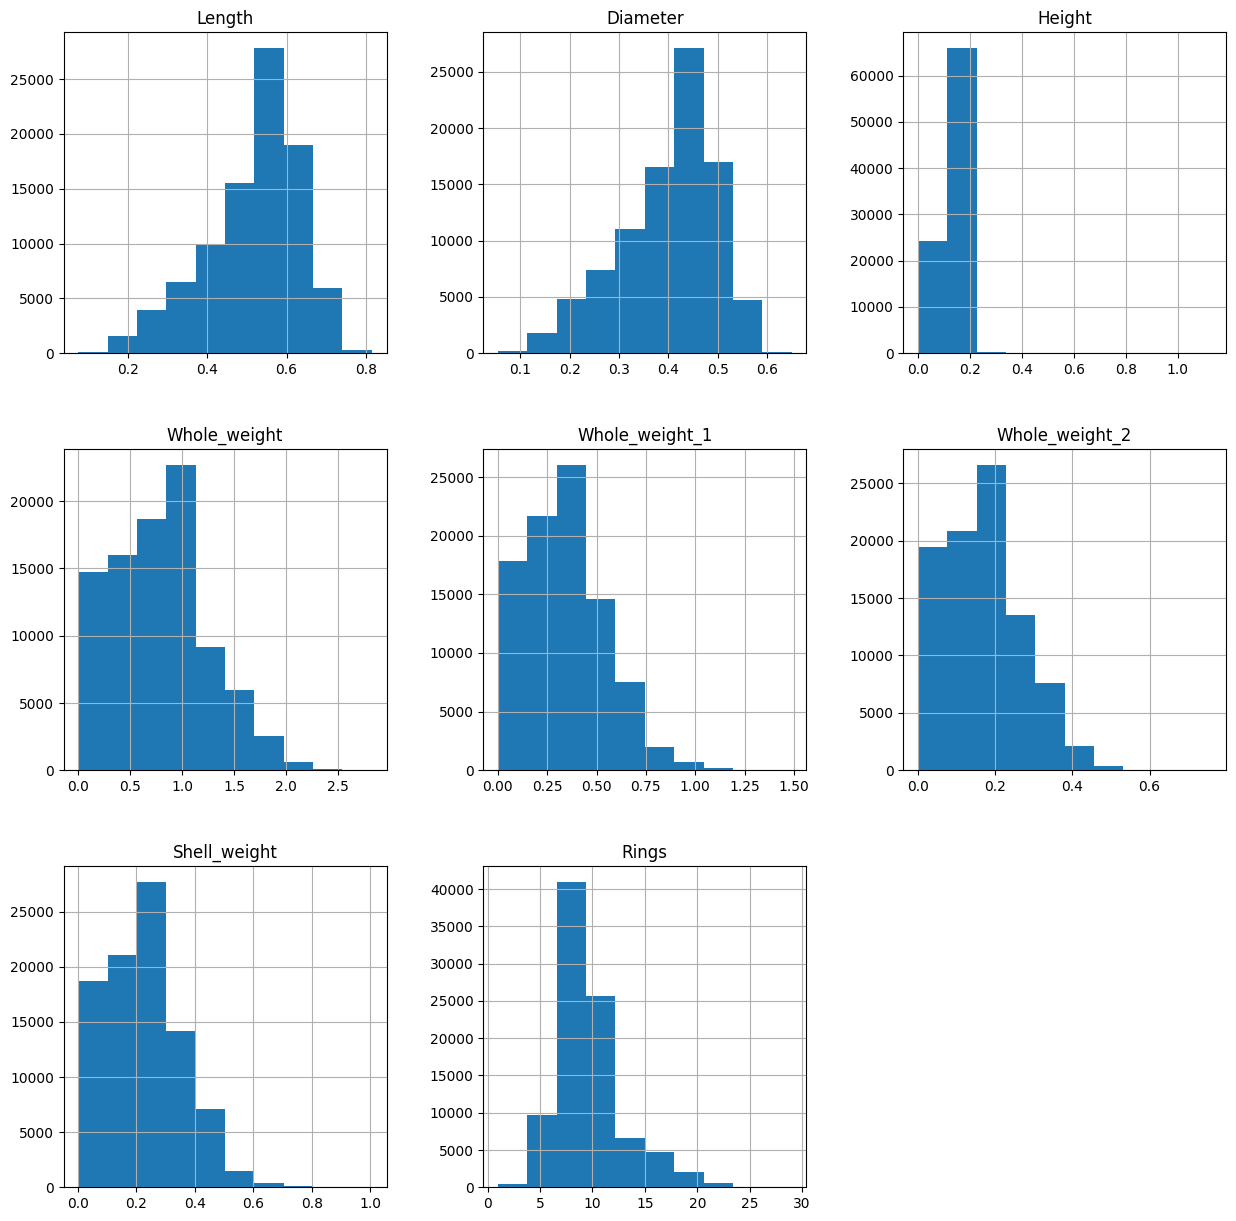

In [23]:
num_cols = train_df.select_dtypes(exclude='object').columns.to_list()
train_df[num_cols].hist(figsize=(15,15))

[Text(0, 0, '33093'), Text(0, 0, '31027'), Text(0, 0, '26495')]

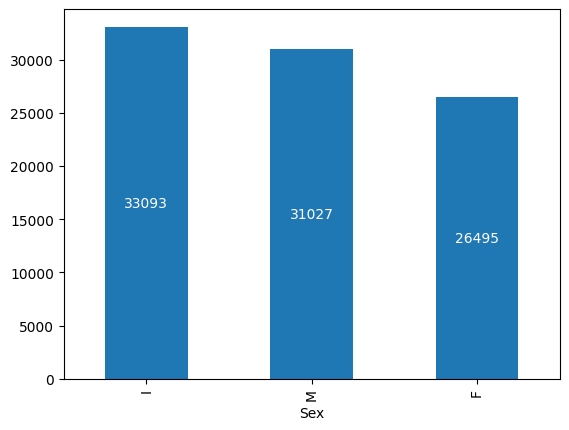

In [24]:
ax = train_df['Sex'].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0], label_type='center', color='white')

<Axes: xlabel='Rings', ylabel='Density'>

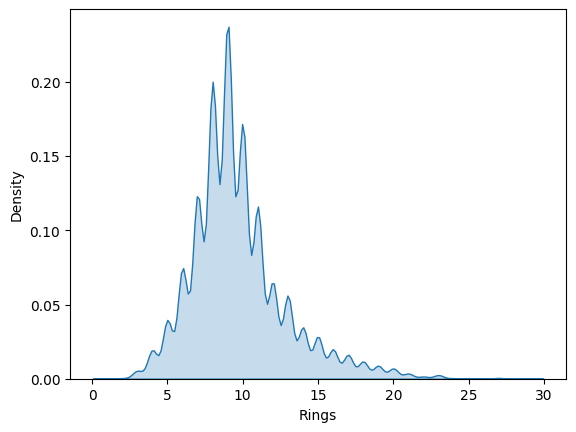

In [25]:
sns.kdeplot(train_df['Rings'], fill=True)

In [28]:
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [37]:
num_cols = list(train_df._get_numeric_data())
cat_cols = list(train_df.drop(num_cols, axis = 1))
target='Rings'
num_cols.remove(target)

In [33]:
import scipy.stats
# skewness = 0 : normally distributed
# skewness > 0 : more weight in the left tail of the distribution
# skewness < 0 : more weight in the right tail of the distribution.

log_features = [f for f in num_cols if (train_df[f] >= 0).all() and scipy.stats.skew(train_df[f])>0]

log_features

['Height',
 'Whole_weight',
 'Whole_weight_1',
 'Whole_weight_2',
 'Shell_weight',
 'Rings']

In [34]:
SEED = 42
splits = 20
kf = StratifiedKFold(n_splits = splits, random_state = SEED, shuffle = True)

In [58]:
def score_model(estimator, label='', include_original_data = True, importance=False):
    X = train_df.copy()
    y = X.pop('Rings')

    val_predictions = np.zeros(len(X))
    test_predictions = np.zeros(len(test_df))
    train_scores, val_scores = [], []

    df_importance = pd.DataFrame({'mean':0,'std':0}, index=list(X.columns))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        model = clone(estimator)

        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)

        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)

        # log_y_train = np.log1p(y_train)
        # print(pd.DataFrame({'Rings': log_y_train.values}))
        # print(type(pd.DataFrame({'Rings': log_y_train.values})))
        # model.fit(X_train, pd.DataFrame({'Rings': log_y_train.values}))
        model.fit(X_train, np.log1p(y_train))
        train_preds = np.expm1(model.predict(X_train))
        val_preds = np.expm1(model.predict(X_val))

        val_predictions[val_idx] += val_preds
        test_predictions += np.expm1(model.predict(test_df)) / kf.get_n_splits()

        train_score = mean_squared_log_error(y_train, train_preds, squared=False)
        val_score = mean_squared_log_error(y_val, val_preds, squared=False)

        train_scores.append(train_score)
        val_scores.append(val_score)

    return val_scores, val_predictions, test_predictions

In [59]:
lgbm_params = {
     'metric':'rmse', 
     'verbosity': -1,
     'max_depth': 15,
     'random_state':SEED,
     'num_leaves': 138, 
     'n_estimators': 913, 
     'boosting_type': 'gbdt', 
     'min_child_samples': 34, 
     'objective':'regression', 
     'subsample_for_bin': 185680, 
     'subsample': 0.799314727120346, 
     'reg_alpha': 5.916235901972299e-09, 
     'reg_lambda': 6.943912907338958e-08, 
     'learning_rate': 0.01851440025520457, 
     'colsample_bytree': 0.4339090795122026, 
}

In [60]:
scores['lgbm'], oof['lgbm'], test_preds['lgbm'] = score_model(make_pipeline(
    ColumnTransformer([
        ('log', FunctionTransformer(np.log1p), log_features),
        ('cat', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False),
    LGBMRegressor(verbose=0, **lgbm_params)
), 'LGBM')

d:\Anaconda\envs\pytorch\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 18 members, which is less than n_splits=20.
  warnings.warn(


ValueError: A given column is not a column of the dataframe